In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
plt.rcParams.update({'font.size': 12})

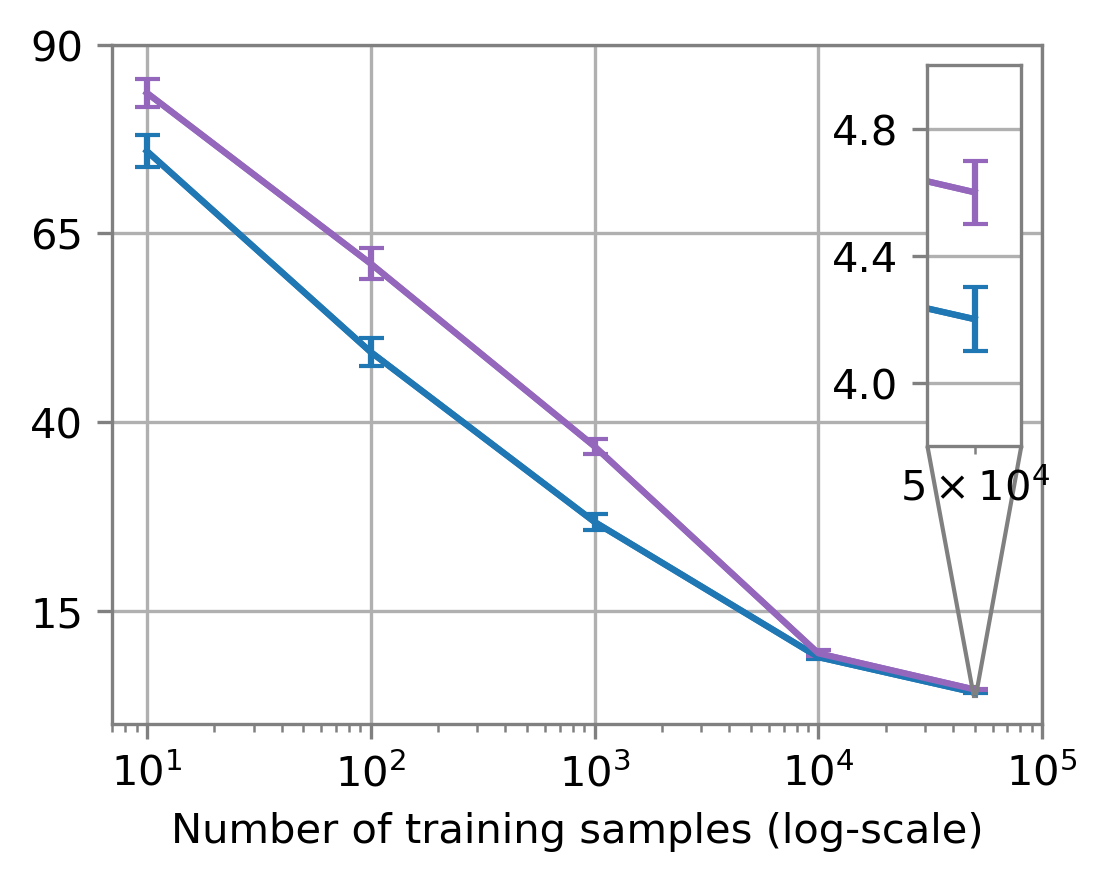

In [2]:
def color_ax(ax, color='gray'):
    ax.grid()
    ax.spines['bottom'].set_color(color)
    ax.spines['top'].set_color(color)
    ax.spines['left'].set_color(color)
    ax.spines['right'].set_color(color)
    ax.tick_params(which='both', color=color)
    
def plot_figure_4a(ax):
    # Reported values in Pre-Train Your Loss
    ax.plot([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], label='SGD Learned Prior', color='#1f77b4')
    ax.errorbar([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], yerr=[2.1, 1.9, 1.1, 0.3, 0.1], capsize=3, color='#1f77b4')
    ax.plot([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], label='SGD Transfer Init', color='#9467bd')
    ax.errorbar([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], yerr=[1.8, 2.1, 1.0, 0.4, 0.1], capsize=3, color='#9467bd')
    # Zoomed section
    axins = zoomed_inset_axes(ax, zoom=42, loc='upper right')
    axins.plot([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], label='SGD Learned Prior', color='#1f77b4')
    axins.errorbar([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], yerr=[2.1, 1.9, 1.1, 0.3, 0.1], capsize=3, color='#1f77b4')
    axins.plot([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], label='SGD Transfer Init', color='#9467bd')
    axins.errorbar([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], yerr=[1.8, 2.1, 1.0, 0.4, 0.1], capsize=3, color='#9467bd')
    axins.set_xlim([49425, 50575])
    axins.set_ylim([3.8, 5.0])
    axins.set_yticks([4.0, 4.4, 4.8])
    axins.set_xscale('log')
    color_ax(axins)
    mark_inset(ax, axins, loc1=3, loc2=4, color='gray')
    # Formatting
    ax.set_xlim([7, 1e5])
    ax.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
    ax.set_yticks([15, 40, 65, 90])
    ax.set_xscale('log')
    color_ax(ax)
    ax.set_xlabel('Number of training samples (log-scale)')
    #ax.set_ylabel('Test error')
    #ax.legend(loc='lower left', fontsize='small')
    
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3), dpi=300)
plot_figure_4a(ax)
plt.show()

In [3]:
def get_df(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    return df

def get_val_loss(df):
    return df.val_or_test_loss.values[-1]

def get_val_acc(df):
    return df.val_or_test_acc.values[-1]

def get_val_nll(df):
    return df.val_or_test_nll.values[-1]

def get_last_epoch(df):
    return df.iloc[-1]

In [4]:
def get_best_hyperparameters(experiments_path, lr_0s, ns, prior_scales, prior_type, random_states, weight_decays):
    columns = ['lr_0', 'n', 'prior_scale', 'prior_type', 'random_state', 'val_acc', 'weight_decay']
    df = pd.DataFrame(columns=columns)
    for n, random_state in itertools.product(ns, random_states):
        best_val_loss = np.inf
        best_hyperparameters = None
        for lr_0, prior_scale, weight_decay in itertools.product(lr_0s, prior_scales, weight_decays):
            if prior_scale:
                model_name = '{}_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
                .format(prior_type, lr_0, n, prior_scale, random_state, weight_decay)
            else:
                model_name = '{}_lr_0={}_n={}_random_state={}_weight_decay={}'\
                .format(prior_type, lr_0, n, random_state, weight_decay)
            path =  '{}/{}.csv'.format(experiments_path, model_name)
            val_loss = get_val_loss(get_df(path))
            val_acc = get_val_acc(get_df(path))
            if val_loss < best_val_loss: best_val_loss = val_loss; best_hyperparameters = [lr_0, n, prior_scale, prior_type, random_state, val_acc, weight_decay]
        df.loc[df.shape[0]] = best_hyperparameters
    return df
    
def get_learned_hyperparameters(experiments_path, lr_0s, ns, prior_scales, prior_type, random_states, weight_decays):
    columns = ['lr_0', 'n', 'prior_scale', 'prior_type', 'random_state', 'weight_decay']
    df = pd.DataFrame(columns=columns)
    for n, random_state in itertools.product(ns, random_states):
        best_val_nll = np.inf
        best_hyperparameters = None
        for prior_scale in prior_scales:
            best_val_loss = np.inf
            best_model_name = None
            best_lr_0 = None
            best_weight_decay = None
            for lr_0, weight_decay in itertools.product(lr_0s, weight_decays):
                model_name = 'learned_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
                .format(lr_0, n, prior_scale, random_state, weight_decay)
                path =  '{}/{}.csv'.format(experiments_path, model_name)
                val_loss = get_val_loss(get_df(path))
                if val_loss < best_val_loss: best_val_loss = val_loss; best_model_name = model_name; best_lr_0 = lr_0; best_weight_decay = weight_decay
            path = '{}/{}.csv'.format(experiments_path, best_model_name)
            val_nll = get_val_nll(get_df(path))
            if val_nll < best_val_nll: best_val_nll = val_nll; best_hyperparameters = [best_lr_0, n, prior_scale, prior_type, random_state, best_weight_decay]
        df.loc[df.shape[0]] = best_hyperparameters
    return df

def get_results(df, experiments_path):
    columns = ['n', 'prior_scale', 'prior_type', 'random_state', 'test_acc', 'test_loss', 'test_nll', 
           'test_prior', 'train_acc', 'train_loss', 'train_nll', 'train_prior']
    results = pd.DataFrame(columns=columns)
    for row_index, row in df.iterrows():
        if row.prior_scale:
            model_name = '{}_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
            .format(row.prior_type, row.lr_0, row.n, row.prior_scale, row.random_state, row.weight_decay)
        else:
            model_name = '{}_lr_0={}_n={}_random_state={}_weight_decay={}'\
            .format(row.prior_type, row.lr_0, row.n, row.random_state, row.weight_decay)
        path =  '{}/{}.csv'.format(experiments_path, model_name)
        last_epoch = get_last_epoch(get_df(path))
        results_row = [int(row.n), row.prior_scale, row.prior_type, int(row.random_state), 
                       last_epoch.val_or_test_acc, last_epoch.val_or_test_loss, 
                       last_epoch.val_or_test_nll, last_epoch.val_or_test_prior, 
                       last_epoch.train_acc, last_epoch.train_loss, 
                       last_epoch.train_nll, last_epoch.train_prior]
        results.loc[results.shape[0]] = results_row
    return results

In [5]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = np.logspace(-1, -4, num=4)
ns = [10, 100, 1000, 10000, 50000]
prior_scales = [None]
prior_type = 'nonlearned'
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
nonlearned_hyperparameters = get_best_hyperparameters(experiments_path, lr_0s, ns, prior_scales, prior_type, random_states, weight_decays)
nonlearned_hyperparameters

,lr_0,n,prior_scale,prior_type,random_state,val_acc,weight_decay
0,0.0001,10,None,nonlearned,1001,0.000000,0.00010
1,0.0100,10,None,nonlearned,2001,0.000000,0.00100
2,0.0010,10,None,nonlearned,3001,0.000000,0.01000
3,0.0001,100,None,nonlearned,1001,0.425000,0.00001
4,0.0001,100,None,nonlearned,2001,0.266667,0.00010
5,0.0001,100,None,nonlearned,3001,0.441667,0.00100
6,0.0100,1000,None,nonlearned,1001,0.863891,0.00100
7,0.0100,1000,None,nonlearned,2001,0.845090,0.00100
8,0.0100,1000,None,nonlearned,3001,0.845111,0.00001
9,0.0100,10000,None,nonlearned,1001,0.935793,0.00100


In [6]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = np.logspace(-1, -4, num=4)
ns = [10, 100, 1000, 10000, 50000]
prior_scales = [None]
prior_type = 'adapted'
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
adapted_hyperparameters = get_best_hyperparameters(experiments_path, lr_0s, ns, prior_scales, prior_type, random_states, weight_decays)
adapted_hyperparameters

,lr_0,n,prior_scale,prior_type,random_state,val_acc,weight_decay
0,0.0001,10,None,adapted,1001,0.000000,0.000000
1,0.0001,10,None,adapted,2001,0.000000,0.000000
2,0.0001,10,None,adapted,3001,0.000000,0.000001
3,0.0100,100,None,adapted,1001,0.475000,0.001000
4,0.0100,100,None,adapted,2001,0.518519,0.001000
5,0.0100,100,None,adapted,3001,0.491667,0.000010
6,0.0100,1000,None,adapted,1001,0.847148,0.001000
7,0.1000,1000,None,adapted,2001,0.846438,0.010000
8,0.0100,1000,None,adapted,3001,0.862882,0.000010
9,0.0100,10000,None,adapted,1001,0.935817,0.010000


In [7]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = np.logspace(-1, -4, num=4)
ns = [10, 100, 1000, 10000, 50000]
prior_scales = np.logspace(0, 9, num=10)
prior_type = 'learned'
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
learned_hyperparameters = get_learned_hyperparameters(experiments_path, lr_0s, ns, prior_scales, prior_type, random_states, weight_decays)
learned_hyperparameters

,lr_0,n,prior_scale,prior_type,random_state,weight_decay
0,0.100,10,1000000.0,learned,1001,0.001000
1,0.001,10,1000000.0,learned,2001,0.010000
2,0.010,10,1000000.0,learned,3001,0.010000
3,0.100,100,1.0,learned,1001,0.000001
4,0.010,100,10.0,learned,2001,0.000000
5,0.010,100,1.0,learned,3001,0.000100
6,0.010,1000,100000000.0,learned,1001,0.001000
7,0.010,1000,100000.0,learned,2001,0.000010
8,0.010,1000,10.0,learned,3001,0.000010
9,0.010,10000,100000.0,learned,1001,0.001000


In [8]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
count = -1
for row_index, row in learned_hyperparameters.iterrows():
    model_name = '{}_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
    .format(row.prior_type, row.lr_0, int(row.n), row.prior_scale, int(row.random_state), row.weight_decay)
    if not os.path.exists('{}/{}.csv'.format(experiments_path, model_name)):
        count += 1
        print('    "python ../src/CIFAR10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --learned_prior --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --prior_scale={} --random_state={} --wandb --weight_decay={}"'\
              .format(dataset_path, experiments_path, row.lr_0, model_name, int(row.n), prior_path, row.prior_scale, int(row.random_state), row.weight_decay))
print(count)

-1


In [9]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
nonlearned_results = get_results(nonlearned_hyperparameters, experiments_path)
adapted_results = get_results(adapted_hyperparameters, experiments_path)
learned_results = get_results(learned_hyperparameters, experiments_path)
results = pd.concat([nonlearned_results, adapted_results, learned_results])
results

,n,prior_scale,prior_type,random_state,test_acc,test_loss,test_nll,test_prior,train_acc,train_loss,train_nll,train_prior
0,10,NaN,nonlearned,1001,0.314585,1.993855,1.993855,0.000000e+00,1.000000,4.883598e-03,0.004884,0.000000e+00
1,10,NaN,nonlearned,2001,0.262714,2.171446,2.171446,0.000000e+00,1.000000,1.578680e-04,0.000158,0.000000e+00
2,10,NaN,nonlearned,3001,0.256007,2.136913,2.136913,0.000000e+00,1.000000,1.504411e-03,0.001504,0.000000e+00
3,100,NaN,nonlearned,1001,0.547119,1.434934,1.434934,0.000000e+00,1.000000,9.883600e-03,0.009884,0.000000e+00
4,100,NaN,nonlearned,2001,0.556731,1.410616,1.410616,0.000000e+00,1.000000,8.884239e-03,0.008884,0.000000e+00
5,100,NaN,nonlearned,3001,0.573320,1.302814,1.302814,0.000000e+00,1.000000,8.902329e-03,0.008902,0.000000e+00
6,1000,NaN,nonlearned,1001,0.827303,0.634889,0.634889,0.000000e+00,1.000000,9.345930e-05,0.000093,0.000000e+00
7,1000,NaN,nonlearned,2001,0.825939,0.634948,0.634948,0.000000e+00,1.000000,9.017519e-05,0.000090,0.000000e+00
8,1000,NaN,nonlearned,3001,0.823771,0.733389,0.733389,0.000000e+00,1.000000,8.721582e-06,0.000009,0.000000e+00
9,10000,NaN,nonlearned,1001,0.934479,0.227405,0.227405,0.000000e+00,1.000000,1.467216e-04,0.000147,0.000000e+00


In [10]:
grouped_results = results.groupby(['n', 'prior_type']).agg(lambda x: tuple(x))
columns = ['test_acc', 'train_acc']
for column in columns:
    grouped_results['{}_mean'.format(column)] = grouped_results[column].apply(lambda item: np.mean(item))
    grouped_results['{}_std'.format(column)] = grouped_results[column].apply(lambda item: np.std(item))
grouped_results = grouped_results.reset_index()
grouped_results

,n,prior_type,prior_scale,random_state,test_acc,test_loss,test_nll,test_prior,train_acc,train_loss,train_nll,train_prior,test_acc_mean,test_acc_std,train_acc_mean,train_acc_std
0,10,adapted,"(nan, nan, nan)","(1001, 2001, 3001)","(0.294614160299, 0.258415282667, 0.278023420632)","(2.03220756435, 2.12110177155, 2.06427456131)","(2.03220756435, 2.12110177155, 2.06427361832)","(0.0, 0.0, 8.78582852692e-07)","(1.00000011921, 1.00000011921, 1.00000011921)","(0.00449390988797, 0.00477414112538, 0.0043149...","(0.00449390988797, 0.00477414112538, 0.0043140...","(0.0, 0.0, 8.78582852692e-07)",0.277018,0.014795,1.000000,0.000000e+00
1,10,learned,"(1000000.0, 1000000.0, 1000000.0)","(1001, 2001, 3001)","(0.161914943457, 0.255319742417, 0.150586461186)","(6093.66311641, 6093.45377891, 6093.64667891)","(2.33645606422, 2.12710054359, 2.31904016304)","(-6091.32666016, -6091.32666016, -6091.32763672)","(1.00000011921, 1.00000011921, 1.00000011921)","(6091327.0, 6091327.0, 6091327.5)","(0.00176986120641, 0.00189576973207, 0.0202203...","(-6091327.0, -6091327.0, -6091327.5)",0.189274,0.046930,1.000000,0.000000e+00
2,10,nonlearned,"(nan, nan, nan)","(1001, 2001, 3001)","(0.314584617901, 0.262713941574, 0.256007477868)","(1.993854669, 2.17144612923, 2.13691278267)","(1.993854669, 2.17144612923, 2.13691278267)","(0.0, 0.0, 0.0)","(1.00000011921, 1.00000011921, 1.00000011921)","(0.00488359760493, 0.000157867951202, 0.001504...","(0.00488359760493, 0.000157867951202, 0.001504...","(0.0, 0.0, 0.0)",0.277769,0.026176,1.000000,0.000000e+00
3,100,adapted,"(nan, nan, nan)","(1001, 2001, 3001)","(0.574541005802, 0.589034591436, 0.562979877996)","(1.36870594845, 1.30362316971, 1.49184090576)","(1.36662670002, 1.30169483948, 1.4917928627)","(0.00207929988392, 0.00192838546354, 4.8084930...","(1.00000011921, 1.00000011921, 1.00000011921)","(0.00224267179146, 0.00208524498157, 7.4619252...","(0.000163371892995, 0.000156859518029, 2.65343...","(0.00207929988392, 0.00192838546354, 4.8084930...",0.575518,0.010659,1.000000,0.000000e+00
4,100,learned,"(1.0, 10.0, 1.0)","(1001, 2001, 3001)","(0.525180930233, 0.585860774755, 0.576085902023)","(-543.404781641, -537.199867871, -543.725924121)","(1.62188979568, 1.32283594093, 1.30074812889)","(545.026672363, 538.522705078, 545.026672363)","(1.00000011921, 1.00000011921, 1.00000011921)","(-54502.671875, -53852.265625, -54502.6601562)","(0.0015760777751, 0.00213141622953, 0.00200851...","(54502.671875, 53852.2695312, 54502.6640625)",0.562376,0.026602,1.000000,0.000000e+00
5,100,nonlearned,"(nan, nan, nan)","(1001, 2001, 3001)","(0.547118593311, 0.556731097937, 0.573320147514)","(1.43493428154, 1.41061631756, 1.30281434135)","(1.43493428154, 1.41061631756, 1.30281434135)","(0.0, 0.0, 0.0)","(1.00000011921, 1.00000011921, 1.00000011921)","(0.00988360028714, 0.00888423901051, 0.0089023...","(0.00988360028714, 0.00888423901051, 0.0089023...","(0.0, 0.0, 0.0)",0.559057,0.010822,1.000000,0.000000e+00
6,1000,adapted,"(nan, nan, nan)","(1001, 2001, 3001)","(0.840537891865, 0.852008073807, 0.8353966362)","(0.573887719059, 0.540441309166, 0.702300250149)","(0.565843050194, 0.530101205063, 0.702094370365)","(0.0080446805805, 0.0103401206434, 0.000205897...","(1.00000011921, 1.00000011921, 1.00000011921)","(0.00812305610627, 0.0107533395812, 0.00021545...","(7.83755108714e-05, 0.000413218838163, 9.55342...","(0.0080446805805, 0.0103401206434, 0.000205897...",0.842648,0.006944,1.000000,0.000000e+00
7,1000,learned,"(100000000.0, 100000.0, 10.0)","(1001, 2001, 3001)","(0.824990023613, 0.832123757458, 0.842854789925)","(11497.5324312, 3445.41948633, -537.946979395)","(0.652522264242, 0.660223971081, 0.574872509289)","(-11496.8798828, -3444.75927734, 538.521850586)","(1.00000011921, 1.00000011921, 1.00000011921)","(114968.796875, 34447.59375, -5385.21819922)","(9.20619563549e-05, 1.3915254749e-05, 0.000223...","(-114968.796875, -34447.59375, 5385.21826172)",0.833323,0.007342,1.000000,0.000000e+00
8,1000,nonlearned,"(nan, nan, nan)","(10

/cluster/tufts/rt/software/jupyter/lib/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


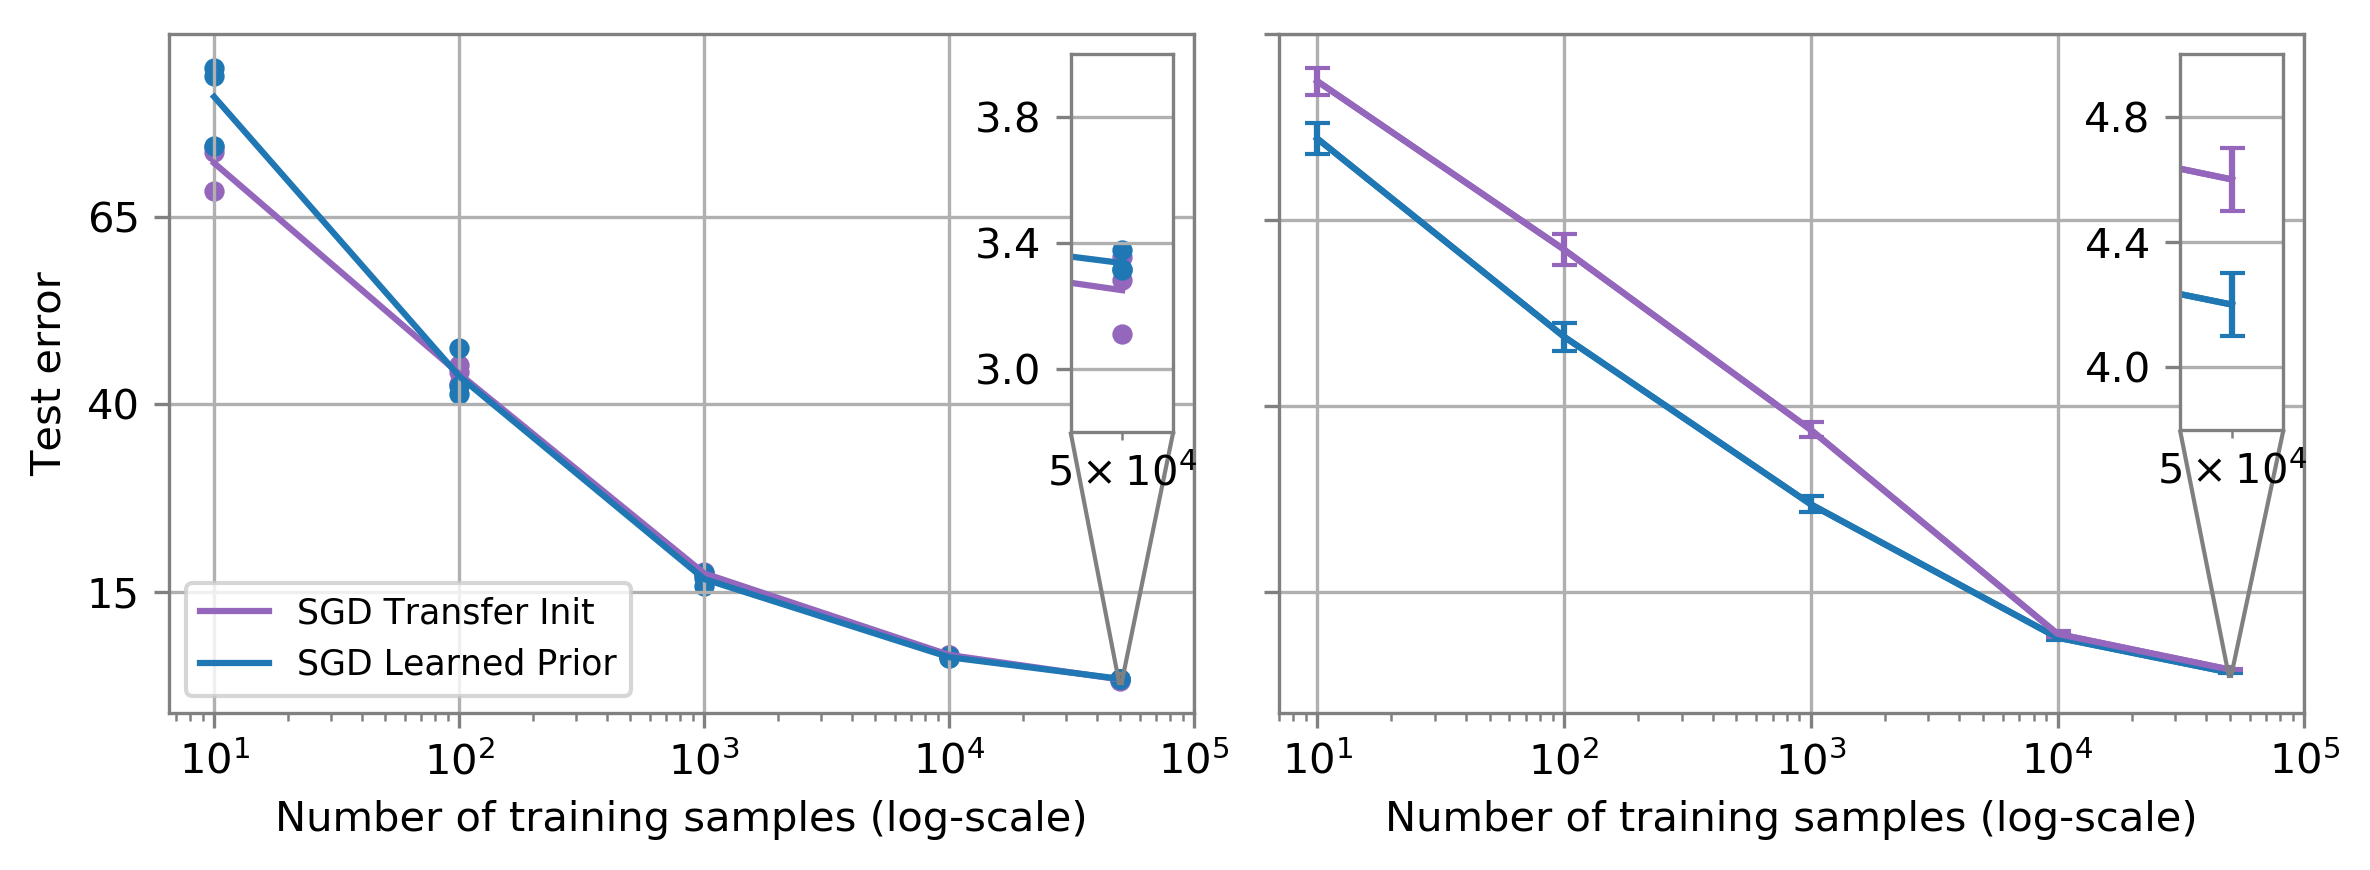

In [11]:
ncols, nrows = 2, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 3*nrows), sharey=True, dpi=300)
axs[0].plot(grouped_results[grouped_results.prior_type=='nonlearned'].n, 100*(1-grouped_results[grouped_results.prior_type=='nonlearned'].test_acc_mean.values), label='SGD Transfer Init', color='#9467bd')
axs[0].scatter(results[results.prior_type=='nonlearned'].n, 100*(1-results[results.prior_type=='nonlearned'].test_acc.values), color='#9467bd', s=15)
axs[0].plot(grouped_results[grouped_results.prior_type=='learned'].n, 100*(1-grouped_results[grouped_results.prior_type=='learned'].test_acc_mean.values), label='SGD Learned Prior', color='#1f77b4')
axs[0].scatter(results[results.prior_type=='learned'].n, 100*(1-results[results.prior_type=='learned'].test_acc.values), color='#1f77b4', s=15)
#axs[0].plot(grouped_results[grouped_results.prior_type=='adapted'].n, 100*(1-grouped_results[grouped_results.prior_type=='adapted'].test_acc_mean.values), label='SGD MAP Adaptation', color='#d62728')
#axs[0].scatter(results[results.prior_type=='adapted'].n, 100*(1-results[results.prior_type=='adapted'].test_acc.values), color='#d62728', s=15)
# Zoomed section
axins = zoomed_inset_axes(axs[0], zoom=42, loc='upper right')
axins.plot(grouped_results[grouped_results.prior_type=='nonlearned'].n, 100*(1-grouped_results[grouped_results.prior_type=='nonlearned'].test_acc_mean.values), color='#9467bd')
axins.scatter(results[results.prior_type=='nonlearned'].n, 100*(1-results[results.prior_type=='nonlearned'].test_acc.values), color='#9467bd', s=15)
axins.plot(grouped_results[grouped_results.prior_type=='learned'].n, 100*(1-grouped_results[grouped_results.prior_type=='learned'].test_acc_mean.values), color='#1f77b4')
axins.scatter(results[results.prior_type=='learned'].n, 100*(1-results[results.prior_type=='learned'].test_acc.values), color='#1f77b4', s=15)
#axins.plot(grouped_results[grouped_results.prior_type=='adapted'].n, 100*(1-grouped_results[grouped_results.prior_type=='adapted'].test_acc_mean.values), color='#d62728')
#axins.scatter(results[results.prior_type=='adapted'].n, 100*(1-results[results.prior_type=='adapted'].test_acc.values), color='#d62728', s=15)
axins.set_xlim([49425, 50575])
axins.set_ylim([2.8, 4.0])
axins.set_yticks([3.0, 3.4, 3.8])
axins.set_xscale('log')
color_ax(axins)
mark_inset(axs[0], axins, loc1=3, loc2=4, color='gray')
# Formatting
axs[0].set_xscale('log')
color_ax(axs[0])
axs[0].set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
axs[0].set_yticks([15, 40, 65, 90])
axs[0].set_xlabel('Number of training samples (log-scale)')
axs[0].set_ylabel('Test error')
axs[0].legend(loc='lower left', fontsize='small')
plot_figure_4a(axs[1])
fig.tight_layout()
plt.savefig('replication.pdf')
plt.show()

In [12]:
grouped_results[['n', 'prior_type', 'test_acc_mean', 'test_acc_std']]

,n,prior_type,test_acc_mean,test_acc_std
0,10,adapted,0.277018,0.014795
1,10,learned,0.189274,0.046930
2,10,nonlearned,0.277769,0.026176
3,100,adapted,0.575518,0.010659
4,100,learned,0.562376,0.026602
5,100,nonlearned,0.559057,0.010822
6,1000,adapted,0.842648,0.006944
7,1000,learned,0.833323,0.007342
8,1000,nonlearned,0.825671,0.001454
9,10000,adapted,0.947725,0.001588
